``Mission : Error Analysis & Model metadata``


# Data and dependencies

In [1]:
import warnings
import sys
import os
import time
import joblib
import random
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from geopy.distance import geodesic

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

warnings.filterwarnings('ignore')

In [2]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

In [3]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [4]:
def dens_to_sev(x: float)-> int:
    """takes in density value in cells/ml and returns severity category"""
    if (x < 20_000) : return 1
    elif (x >= 20_000) and (x < 100_000) : return 2
    elif (x >= 100_000) and (x < 1_000_000) : return 3
    elif (x >= 1_000_000) and (x < 10_000_000) : return 4
    elif x > 10_000_000 : return 5

## Add date fts

In [5]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week


seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

metadata['season'] = metadata.month.map(seasons)


region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

data = pd.merge(metadata, region, on='uid', how='left')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0


In [6]:
test_data = data[data.split == 'test']
test_data.shape, data.shape

((6510, 12), (23570, 12))

In [7]:
train_data = data[data.split == 'train']
train_data.shape, data.shape

((17060, 12), (23570, 12))

# Utils

In [8]:
#  Utils
def get_data_by_date( date=None, data=train_data):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

def analyize_matches(y_true, y_pred):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))

In [9]:
te_data = test_data.sort_values(by='date')
te_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
6865,howw,37.0062,-120.600,2013-01-08,test,2013,1,2,1,west,NaN,NaN
3661,eamn,36.9818,-120.221,2013-01-08,test,2013,1,2,1,west,NaN,NaN
7668,imsv,36.9836,-120.500,2013-01-08,test,2013,1,2,1,west,NaN,NaN
20182,wgxq,33.8011,-117.205,2013-01-25,test,2013,1,4,1,west,NaN,NaN
16095,rsos,33.8892,-117.562,2013-01-25,test,2013,1,4,1,west,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.7368,-121.734,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.7518,-121.742,2021-12-29,test,2021,12,52,1,west,NaN,NaN
6864,howu,36.7085,-121.749,2021-12-29,test,2021,12,52,1,west,NaN,NaN
6540,hfvr,36.7962,-121.782,2021-12-29,test,2021,12,52,1,west,NaN,NaN


## Train test split

In [10]:
tr_data, val_data = train_test_split(train_data, test_size=0.15, random_state=123456789, shuffle=True)
tr_data.shape, val_data.shape

((14501, 12), (2559, 12))

In [11]:
tr_data2, val_data2 = train_test_split(train_data, test_size=0.15, random_state=123456789, shuffle=True)
tr_data2.shape, val_data2.shape

((14501, 12), (2559, 12))

## Guess Funcs

In [12]:
fill_2s = []
g_from_past = {}

n_times_called = {}

def make_guess1(row: pd.Series, date=None, tr_data=tr_data) -> pd.Series:

    dists = []
    region = row.region
    date = date
    uid = row.uid
    tr_data = tr_data

    if date is None:
        date = row.date

    rel_data = tr_data[(tr_data.date == date) & (tr_data.region == region)]
    
    # check if cur date is past '2013-01-04'
    if date < pd.to_datetime('2013-01-04'):
        print(f'No previous data for this date filling in 2s .. for {row.uid}')
        fill_2s.append(uid)
        return 2

    if rel_data.shape[0] == 0:
        # print(f'No data for this date, trying previous day.. for {row.uid}')
        if g_from_past.get(uid) is not None:
            g_from_past[uid] += 1
        return make_guess1(row, date=date - pd.Timedelta(days=1), tr_data=tr_data)

    for some_row in rel_data.itertuples():
        dist = get_distance(row.latitude, row.longitude, some_row.latitude, some_row.longitude)
        dists.append(dist)
    
    nearest = rel_data.iloc[np.argmin(dists)]
    return nearest.severity


def make_guess2(row: pd.Series, date=None, tr_data=tr_data, n_times_called=None) -> pd.Series:
    """modified version of make_guess1, Uses mean/mode of severity for the region instead of nearest severity."""
    dists = []
    region = row.region
    date = date
    uid = row.uid
    tr_data = tr_data
    
    if n_times_called is not None:
        if n_times_called.get(uid) is None:
            n_times_called[uid] = 1
        else:
            n_times_called[uid] += 1
        

    if date is None:
        date = row.date

    rel_data = tr_data[(tr_data.date == date) & (tr_data.region == region)]
    
    # check if cur date is past '2013-01-04'
    if date < pd.to_datetime('2013-01-04'):
        print(f'No previous data for this date filling in 2s .. for {row.uid}')
        fill_2s.append(uid)
        return 2

    if rel_data.shape[0] == 0:
        # print(f'No data for this date, trying previous day.. for {row.uid}')
        if g_from_past.get(uid) is not None:
            g_from_past[uid] += 1
        global count 
        count += 1
        return make_guess2(row, date=date - pd.Timedelta(days=1), tr_data=tr_data)

    severty_mode = rel_data.severity.mode()[0]
    severty_mean = np.round(rel_data.severity.mean())

    return severty_mean



def cv_loop(rand, splits=10, guess_func=make_guess1):
    # print("Random Number: ", rand)
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=rand)
    tscv = TimeSeriesSplit(n_splits=splits)
    
    rmses = []
    guess_train_preds = np.zeros((train_data.shape[0]))

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data, train_data.severity)):
        print(f"Fold: {fold}")
        tr_data, val_data = train_data.iloc[train_idx], train_data.iloc[val_idx]

        val_data['guess'] = 0

        temp = []
        for row in tqdm(val_data.itertuples(), total=val_data.shape[0]):
            uid_series = val_data[val_data.uid == row.uid]
            severity = guess_func(uid_series.iloc[0], date=row.date, tr_data=tr_data)
            val_data.loc[val_data.uid == row.uid, f'guess'] = severity
            temp.append(severity)
        
        guess_train_preds[val_idx] = temp
        

                
        errror = rmse(val_data.severity, val_data.guess1)
        rmses.append(errror)
        print("RMSE: ", errror)

        print('Train Distribution: ')
        print(tr_data.severity.value_counts(normalize=True))
        print('Val Distribution: ')
        print(val_data.severity.value_counts(normalize=True))
        print('Predicted Distribution: ')
        print(val_data.guess1.value_counts(normalize=True))

    
    print('----------------------------------------------------')

    return rmses, guess_train_preds


In [13]:
tr_data.sort_values(by='date', inplace=True)
val_data.sort_values(by='date', inplace=True)

In [14]:
tr_data2.sort_values(by='date', inplace=True)
val_data2.sort_values(by='date', inplace=True)

### Failed way of validation

In [15]:
# 0.08284486127393513 + 0.008206330597889801 + 0.0011723329425556857
# 91% preds < 1 offs, 99% preds < 2 offs, 88% preds == 2 offs

### New Era VAL SET

In [16]:
val_data2['date_reg'] = val_data2.date.astype(str) + "_" +  val_data2.region
tr_data2['date_reg'] = tr_data2.date.astype(str) + "_" +  tr_data2.region

assert (val_data2.columns == tr_data2.columns).all()

print(set(val_data2.uid).intersection(set(tr_data2.uid)))

#  Intersection percentage of date and regs before
print(len(set(val_data2.date_reg).intersection(set(tr_data2.date_reg)))/val_data2.date_reg.nunique())

set()
0.9328793774319066


In [17]:
datereg_to_remove = val_data2.date_reg.sample(frac=0.40, random_state=123456789)
tr_data2_ = tr_data2[~tr_data2.date_reg.isin(datereg_to_remove)]

len(set(val_data2.date_reg).intersection(set(tr_data2_.date_reg)))/val_data2.date_reg.nunique()

0.372568093385214

In [18]:
len(set(val_data2.date).intersection(set(tr_data2_.date)))/val_data2.date.nunique()

0.6537013801756587

In [19]:
len(set(test_data.date).intersection(set(train_data.date)))/test_data.date.nunique()

0.701095461658842

In [20]:
tr_data2_.shape, val_data2.shape, train_data.shape, val_data.shape

((5712, 13), (2559, 13), (17060, 12), (2559, 12))

In [21]:
tr_data3 = tr_data2.copy()
val_data3 = val_data2.copy()

datereg_to_remove = tr_data3.date_reg.sample(frac=0.60, random_state=123456789)
val_data3_ = val_data3[~val_data3.date_reg.isin(datereg_to_remove)]

len(set(val_data3_.date_reg).intersection(set(tr_data3.date_reg)))/val_data3_.date_reg.nunique()

0.43902439024390244

In [22]:
len(set(val_data3_.date).intersection(set(tr_data2_.date)))/val_data3_.date.nunique()

0.6186440677966102

In [23]:
val_data3.shape, val_data3_.shape, tr_data3.shape

#  I wonder if this is a good idea!

((2559, 13), (137, 13), (14501, 13))

In [24]:
# Don't foreget to clip values and trees are not good at extrapolation!!

# Guess based on nearest neighbors

In [25]:
train_data.groupby('region').severity.mean()

region
midwest      2.194091
northeast    1.805774
south        1.567652
west         3.747413
Name: severity, dtype: float64

In [26]:
reg_sev_map = {
    'midwest': 2,
    'northeast': 2,
    'south' : 2,
    'west' : 4
}

In [27]:
def knn(row=None, train_data=tr_data, k=1):
    """
    row : pd.Series (row from val_data)
    train_data : pd.DataFrame (all_data)
    k : int number of nearest neighbours to consider
    
    algo:
    1. Get past month data collected till the current row
    2. Get the k nearest neighbours (geodesic dist using lat, lng) from the above data
    3. Get the mean of the severity from the above rows
    4. Return the mean of the nearest neighbours severity

    """
    
    if row is None:
        print('Row None bruv!')
        return None
    
    uid = row.uid
    date = row.date
    region = row.region
    past_date = date - pd.Timedelta(days=30)
    
    past_month_data = train_data[(train_data.date < date) & (train_data.date >= past_date)]
    past_month_data.sort_values(by='date', inplace=True)
    
    # if no past data, return the mean of the region
    if len(past_month_data) == 0:
        return reg_sev_map[region]

    
    dist_matrix =pd.DataFrame(columns=['uid', 'dist'])       # 0th col for uid, 1st col for dist
    for i, past_row in enumerate(past_month_data.itertuples()):
        dist_matrix.loc[i, 'uid'] = past_row.uid
        dist_matrix.loc[i, 'dist'] = get_distance(row.latitude, row.longitude, past_row.latitude, past_row.longitude)  # returns geodesic dist in km

    # get top k nearest neighbours
    n_uids = dist_matrix.sort_values(by='dist').head(k).uid.values
    nn_severity = train_data[train_data.uid.isin(n_uids)].severity.mean()
    
    return np.round(nn_severity)


In [28]:
val_data.uid.isin(tr_data.uid).sum()

0

In [45]:
#  iterate over val_data and get the severity for each row

k = 9

for row in tqdm(val_data.itertuples(), total=val_data.shape[0]):
    severity = knn(row, train_data=tr_data, k=k)
    val_data.loc[val_data.uid == row.uid, f'nn{k}_guess'] = severity

100%|██████████| 2559/2559 [03:36<00:00, 11.83it/s]


In [47]:
rmse(val_data.severity, val_data.nn9_guess)

0.894165010958815

In [48]:
# k=1 0.9515418063860925
# k=2 0.9511310393449847
# k=3 0.9076118558993864
# k=4 0.8820647913897578
# k=5 0.8738303744155784
# k=6 0.8884654455787772
# k=7 0.8873651783510002
# k=8 0.8853812517340963
# k=9 0.894165010958815

In [128]:
tr_data2.shape, val_data2.shape, tr_data2_.shape

((14501, 13), (2559, 13), (5712, 13))

In [54]:
val_data2.uid.isin(tr_data2_.uid).sum()

0

In [49]:
for row in tqdm(val_data2.itertuples(), total=val_data2.shape[0]):
    severity = knn(row, train_data=tr_data2_, k=7)
    val_data2.loc[val_data2.uid == row.uid, f'nn7_guess'] = severity

100%|██████████| 2559/2559 [01:34<00:00, 27.22it/s]


In [50]:
rmse(val_data2.severity, val_data2.nn7_guess)

1.031546186165721

In [51]:
tr_data3.shape, val_data3.shape, val_data3_.shape

((14501, 13), (2559, 13), (137, 13))

In [55]:
val_data3_.uid.isin(tr_data3.uid).sum()

0

In [52]:
for row in tqdm(val_data3_.itertuples(), total=val_data3_.shape[0]):
    severity = knn(row, train_data=tr_data3, k=7)
    val_data3_.loc[val_data3_.uid == row.uid, f'nn7_guess'] = severity

100%|██████████| 137/137 [00:13<00:00, 10.48it/s]


In [53]:
rmse(val_data3_.severity, val_data3_.nn7_guess)

0.9628121827594793

2559

# analysis

In [28]:
#  what is happeining with same locs with different dates?

train_data['latlng'] = train_data.latitude.astype(str) + "_" + train_data.longitude.astype(str)
train_data.latlng.nunique()

10614

In [29]:
train_data.latlng.value_counts()

42.027378_-78.967089          94
37.2953_-120.85               87
38.307_-121.794               84
37.2486_-120.851              82
37.8717_-121.526              80
                              ..
37.54089_-84.17999             1
36.00756_-78.9699050458004     1
36.15_-79.1064257262116        1
39.29887_-86.70253             1
35.742_-79.2386004172335       1
Name: latlng, Length: 10614, dtype: int64

In [33]:
x = train_data[train_data.latlng == '42.027378_-78.967089'].sort_values(by='date')
x

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,latlng
19255,vfen,42.027378,-78.967089,2013-07-30,train,2013,7,31,3,northeast,2.0,72756.911765,42.027378_-78.967089
19085,vapz,42.027378,-78.967089,2013-08-05,train,2013,8,32,3,northeast,2.0,61995.153846,42.027378_-78.967089
13032,ojna,42.027378,-78.967089,2013-08-12,train,2013,8,33,3,northeast,2.0,40313.070175,42.027378_-78.967089
22282,yohx,42.027378,-78.967089,2013-08-26,train,2013,8,35,3,northeast,2.0,33216.507937,42.027378_-78.967089
4302,esyw,42.027378,-78.967089,2013-09-02,train,2013,9,36,4,northeast,2.0,56034.271978,42.027378_-78.967089
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11553,mser,42.027378,-78.967089,2020-09-14,train,2020,9,38,4,northeast,2.0,50474.416667,42.027378_-78.967089
20960,xdjr,42.027378,-78.967089,2020-09-22,train,2020,9,39,4,northeast,2.0,74289.722222,42.027378_-78.967089
8243,jdev,42.027378,-78.967089,2020-09-28,train,2020,9,40,4,northeast,3.0,781050.000000,42.027378_-78.967089
20161,wghb,42.027378,-78.967089,2020-10-09,train,2020,10,41,4,northeast,1.0,4103.134557,42.027378_-78.967089


In [47]:
y = train_data[train_data.latlng == '37.2953_-120.85'].sort_values(by='date')
y

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,latlng
19257,vfgn,37.2953,-120.85,2013-01-08,train,2013,1,2,1,west,4.0,4265000.0,37.2953_-120.85
18255,ucgt,37.2953,-120.85,2014-02-10,train,2014,2,7,1,west,4.0,4845000.0,37.2953_-120.85
20122,wfac,37.2953,-120.85,2014-03-03,train,2014,3,10,2,west,4.0,1462500.0,37.2953_-120.85
21828,ybtu,37.2953,-120.85,2014-04-08,train,2014,4,15,2,west,4.0,4505000.0,37.2953_-120.85
6860,hovw,37.2953,-120.85,2014-05-13,train,2014,5,20,2,west,4.0,5347500.0,37.2953_-120.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13925,pilu,37.2953,-120.85,2021-05-11,train,2021,5,19,2,west,4.0,3765000.0,37.2953_-120.85
9834,kuuk,37.2953,-120.85,2021-06-08,train,2021,6,23,3,west,4.0,5160000.0,37.2953_-120.85
13042,ojrp,37.2953,-120.85,2021-07-14,train,2021,7,28,3,west,4.0,5025000.0,37.2953_-120.85
21220,xlbp,37.2953,-120.85,2021-08-10,train,2021,8,32,3,west,4.0,5285000.0,37.2953_-120.85


In [48]:
y.severity.value_counts()

4.0    87
Name: severity, dtype: int64

In [49]:
#  which region got highest variations in severity?

train_data.groupby('region').severity.std().sort_values(ascending=False)


region
midwest      1.043424
northeast    0.938980
south        0.783326
west         0.715230
Name: severity, dtype: float64

<AxesSubplot:>

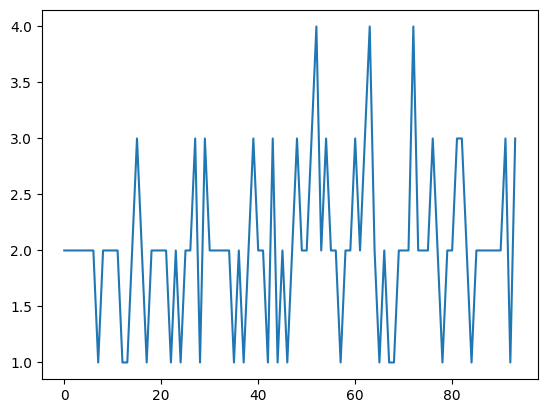

In [44]:
x.severity.reset_index(drop=True).plot()

# CV it

In [ ]:
X_train = train_data.drop(['severity', 'uid', 'date'], axis=1)
y_train = train_data.severity

In [ ]:
xgb = XGBRegressor(n_estimators=1000, random_state=123456789, tree_method='gpu_hist', gpu_id=0)
xgb

In [ ]:

def train_eval(model, X_train=None, X_val=None, y_train=None, y_val=None, X_test=None, y_test=None):
    """
    train and eval util func,
    returns trained model, soft_preds, and rmse
    REMEMBER to round myself
    """
    
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = mse(y_val, np.round(preds), squared=False)
    test_rmse = mse(y_test, np.round(model.predict(X_test)), squared=False)
    print("Train RMSE: ", mse(y_train, np.round(model.predict(X_train)), squared=False))
    print("Val RMSE:", rmse)
    print('TEST RMSE: ', test_rmse)
    
    # print("TEST RMSE:", mse(y_val, np.round(model.predict(X_val)), squared=False))
    return model, preds, rmse, test_rmse


def cv_it(model, X_train=X_train, y_train=y_train, X_test=None, y_test=None, splits=10, cv_predict=False):
#     skf = StratifiedKFold(n_splits=splits, random_state=config.RANDOM_STATE, shuffle=True)
    
    tscv = TimeSeriesSplit(n_splits=splits, test_size=200)
    
    val_rmse = []
    test_rmses = []
    
    if cv_predict:
        cvpreds_test = np.zeros(shape=(6510, splits))
        cvpreds_train = np.zeros(shape=(len(X_train)))

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train, y_train)):

        print(f'-----------------------Fold-{fold}-------------------------')
        X_train_subset, y_train_subset = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        print(f'Training on {X_train_subset.shape[0]} samples' )
        print(f'Validating on {X_val_subset.shape[0]} samples' )

        model, val_preds, rmse, test_rmse= train_eval(
                                    model=model, 
                                    X_train=X_train_subset, 
                                    y_train=y_train_subset, 
                                    X_val=X_val_subset, 
                                    y_val=y_val_subset,
                                    X_test=X_test,
                                    y_test=y_test)
        val_rmse.append(rmse)
        test_rmses.append(test_rmse)
        
        if cv_predict:
            # save predictions for ensembling
            cvpreds_test[:, fold] = model.predict(X_test)
            cvpreds_train[val_idx] = val_preds
                    
    print()
    print("Mean Val RMSE:", np.mean(val_rmse), "std:", np.std(val_rmse))
    print("Mean Test RMSE:", np.mean(test_rmses), "std:", np.std(test_rmses))

    
    if cv_predict:
        return cvpreds_test, cvpreds_train

In [ ]:
cv_it(xgb, X_test=X_val, y_test=y_val)

-----------------------Fold-0-------------------------
Training on 3756 samples
Validating on 1000 samples
Train RMSE:  0.40497439406819935
Val RMSE: 0.9523654760647301
TEST RMSE:  0.9606356350066096
-----------------------Fold-1-------------------------
Training on 4756 samples
Validating on 1000 samples
Train RMSE:  0.4433889672540245
Val RMSE: 0.8012490249604052
TEST RMSE:  0.9506592589536919
-----------------------Fold-2-------------------------
Training on 5756 samples
Validating on 1000 samples
Train RMSE:  0.4450328126200894
Val RMSE: 0.8882567196480982
TEST RMSE:  0.9149683438337731
-----------------------Fold-3-------------------------
Training on 6756 samples
Validating on 1000 samples
Train RMSE:  0.47182298915642806
Val RMSE: 0.8276472678623424
TEST RMSE:  0.8819552348728436
-----------------------Fold-4-------------------------
Training on 7756 samples
Validating on 1000 samples
Train RMSE:  0.4760916177252889
Val RMSE: 0.9813256340277675
TEST RMSE:  0.8283344822762391
---

In [ ]:
tr_data2_new = tr_data2_.copy()
val_data2_new = val_data2.copy()

X_train2 = tr_data2_new.drop(drop_cols, axis=1)
y_train2 = tr_data2_new['severity']
X_val2 = val_data2_new.drop(drop_cols, axis=1)
y_val2 = val_data2_new['severity']

X_train2['region'] = X_train2['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4}) 
X_train2.week = X_train2.week.astype('int')
X_val2['region'] = X_val2['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4})
X_val2.week = X_val2.week.astype('int')

X_val2.drop('date_reg', axis=1, inplace=True)
X_train2.drop('date_reg', axis=1, inplace=True)

X_train2.head()

,latitude,longitude,year,month,week,season,region
13644,44.822478,-93.367962,2013,1,1,1,1
4387,44.847993,-93.476318,2013,1,1,1,1
5566,44.877646,-93.557842,2013,1,1,1,1
6144,44.878889,-93.490833,2013,1,1,1,1
5317,44.850500,-93.515700,2013,1,1,1,1


In [ ]:
assert (X_val2.columns == X_train2.columns).all()

In [ ]:
cv_it(xgb, X_train=X_train2, y_train=y_train2, X_test=X_val2, y_test=y_val2)

-----------------------Fold-0-------------------------
Training on 3712 samples
Validating on 200 samples
Train RMSE:  0.3207950790748211
Val RMSE: 0.8306623862918074
TEST RMSE:  0.8257766010973492
-----------------------Fold-1-------------------------
Training on 3912 samples
Validating on 200 samples
Train RMSE:  0.3091977878052171
Val RMSE: 0.5196152422706632
TEST RMSE:  0.8219820877364625
-----------------------Fold-2-------------------------
Training on 4112 samples
Validating on 200 samples
Train RMSE:  0.3153806914583502
Val RMSE: 0.7905694150420949
TEST RMSE:  0.7963869172221666
-----------------------Fold-3-------------------------
Training on 4312 samples
Validating on 200 samples
Train RMSE:  0.3083561057294485
Val RMSE: 1.036822067666386
TEST RMSE:  0.8073519158712397
-----------------------Fold-4-------------------------
Training on 4512 samples
Validating on 200 samples
Train RMSE:  0.3122782901459112
Val RMSE: 0.6324555320336759
TEST RMSE:  0.7924516891030828
-----------

In [ ]:
0.7826725928953457  + 0.14806624304842844

0.9307388359437742

In [ ]:
xgb.fit(X_train2, y_train2)
preds = xgb.predict(X_val2)  # new validation set with lng and lats !
preds = np.clip(np.round(preds), 1, 5)
rmse(y_val2, preds)

0.806625553226778

In [ ]:
pd.Series(preds).apply(np.round).clip(1, 5).value_counts(normalize=True)

1.0    0.364596
2.0    0.305588
4.0    0.199297
3.0    0.129347
5.0    0.001172
dtype: float64

In [ ]:
tr_data3new = tr_data3.copy()
val_data3__new = val_data3_.copy()

X_train3 = tr_data3new.drop(drop_cols, axis=1)
y_train3 = tr_data3new['severity']
X_val3 = val_data3__new.drop(drop_cols, axis=1)
y_val3 = val_data3__new['severity']

X_train3['region'] = X_train3['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4}) 
X_train3.week = X_train3.week.astype('int')
X_val3['region'] = X_val3['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4})
X_val3.week = X_val3.week.astype('int')

X_val3.drop('date_reg', axis=1, inplace=True)
X_train3.drop('date_reg', axis=1, inplace=True)

X_train3.head()

,latitude,longitude,year,month,week,season,region
13644,44.822478,-93.367962,2013,1,1,1,1
4387,44.847993,-93.476318,2013,1,1,1,1
5566,44.877646,-93.557842,2013,1,1,1,1
6144,44.878889,-93.490833,2013,1,1,1,1
5317,44.850500,-93.515700,2013,1,1,1,1


In [148]:
xgb.fit(X_train3, y_train3)
preds = xgb.predict(X_val3)  # new validation set with lng and lats !
preds = np.clip(np.round(preds), 1, 5)
rmse(y_val3, preds)

0.8014585244561053

In [150]:
X_train3['latlng'] = X_train3['latitude'].astype('str') + X_train3['longitude'].astype('str')
X_val3['latlng'] = X_val3['latitude'].astype('str') + X_val3['longitude'].astype('str')

len(set(X_train3.latlng.unique()) & set(X_val3.latlng.unique()))/len(X_val3)

0.49635036496350365

# Submission

In [ ]:
drop_cols = []

In [ ]:
te_data.drop(drop_cols, axis=1, inplace=True)
te_data['region'] = te_data['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4})
te_data.week = te_data.week.astype('int')
te_data.drop('date', axis=1, inplace=True)

te_data.head()

,latitude,longitude,year,month,week,season,region
1,36.559700,-121.51000,2016,8,35,3,2
12,33.042600,-117.07600,2014,11,44,4,2
14,40.703968,-80.29305,2015,8,35,3,4
15,38.972500,-94.67293,2019,8,35,3,1
16,34.279000,-118.90500,2018,1,2,1,2


In [ ]:
assert (X_train.columns == te_data.columns).all()

In [ ]:
#  Making submission with xgbreg on trained on lng and lat

sub_format['severity'] = 0
test_preds = xgb.predict(te_data)
sub_format['severity'] = np.round(test_preds)

sub_format['severity'] = sub_format['severity'].astype('int')
# clip preds betwee 1 and 5
sub_format['severity'] = sub_format['severity'].clip(1, 5)
sub_format.severity.value_counts(normalize=True)

2    0.315975
1    0.252535
4    0.245315
3    0.183410
5    0.002765
Name: severity, dtype: float64

In [ ]:
#  save submission
#  this is corrected submission!
sub_format.to_csv('../submissions/to submit/xgbreg1k_latlng.csv', index=False)

# Sooo....

- Now I know I don't have clear validation strategy.
- I don't know what to infer from all these experiments.

# Todos :

- 